In [1]:
# !kaggle competitions download -c playground-series-s5e3
# !unzip -u *.zip

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, TargetEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

KAGGLE_RUN = False
if KAGGLE_RUN:
    working_dir = Path('/kaggle/input/playground-series-s5e3')
else:
    working_dir = Path().cwd()

In [3]:
train_df = pd.read_csv(working_dir/'train.csv', index_col='id')
test_df = pd.read_csv(working_dir/'test.csv', index_col='id')


In [4]:
train_df

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int64  
 1   pressure       2190 non-null   float64
 2   maxtemp        2190 non-null   float64
 3   temparature    2190 non-null   float64
 4   mintemp        2190 non-null   float64
 5   dewpoint       2190 non-null   float64
 6   humidity       2190 non-null   float64
 7   cloud          2190 non-null   float64
 8   sunshine       2190 non-null   float64
 9   winddirection  2190 non-null   float64
 10  windspeed      2190 non-null   float64
 11  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 222.4 KB


11 columns, all numeric, 2 int columnns, 9 floats, 2190 entries and all columns filled/ no missing data

In [6]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
day,2190.0,179.948402,105.203592,1.0,89.000,178.50,270.000,365.0
pressure,2190.0,1013.602146,5.655366,999.0,1008.600,1013.00,1017.775,1034.6
maxtemp,2190.0,26.365799,5.654330,10.4,21.300,27.80,31.200,36.0
temparature,2190.0,23.953059,5.222410,7.4,19.300,25.50,28.400,31.5
mintemp,2190.0,22.170091,5.059120,4.0,17.700,23.85,26.400,29.8
dewpoint,2190.0,20.454566,5.288406,-0.3,16.800,22.15,25.000,26.7
humidity,2190.0,82.036530,7.800654,39.0,77.000,82.00,88.000,98.0
cloud,2190.0,75.721918,18.026498,2.0,69.000,83.00,88.000,100.0
sunshine,2190.0,3.744429,3.626327,0.0,0.400,2.40,6.800,12.1
winddirection,2190.0,104.863151,80.002416,10.0,40.000,70.00,200.000,300.0


day column running from 1 to 365, appears that 2190/365 = 6 entries per day  
pressure column, running from 999 to 1034, reasonable range from pressure in mmhg  
maxtemp column, running from 10.4 to 36.0 degree C,  
temparature column (typo, use to research original dataset?), 7.4 to 31.5, does not quite align with maxtemp  
mintemp column, 4.0 to 29.8 degree C, seems to align with maxtemp column,   
dewpoint column, -0.3 to 26.7 degree C, can crosscheck with calculations to extract more information, or verify,  
humidity column, 39.0 to 98.0 %, appears reasonable  
cloud column, 2.0 to 100.0, cloud cover in %  
sunshine column, 0.0 to 12.1, check which unit is used, and how work with cloud cover, 100.0 cloud cover should correspond with 100.0 % cloud cover day  
winddirection column, 10.0 to 300.0 , probably degree, initially appears as given in 10 degree steps, no 0 degree or more than 300 is odd?  
windspeed column, 4.4 to 59.5, maybe km/h, check how windspeeds correlated with winddirection  
rainfall column, target column, 0.0 to 1.0, probability  
  
generally appears as sensible data without obvious outliers  


In [7]:
NUMERIC_COLUMNS=['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
CATEGORIC_COLUMNS=[]
TARGET_COLUMN=['rainfall']
ALL_COLUMNS=NUMERIC_COLUMNS+CATEGORIC_COLUMNS+TARGET_COLUMN

<Axes: >

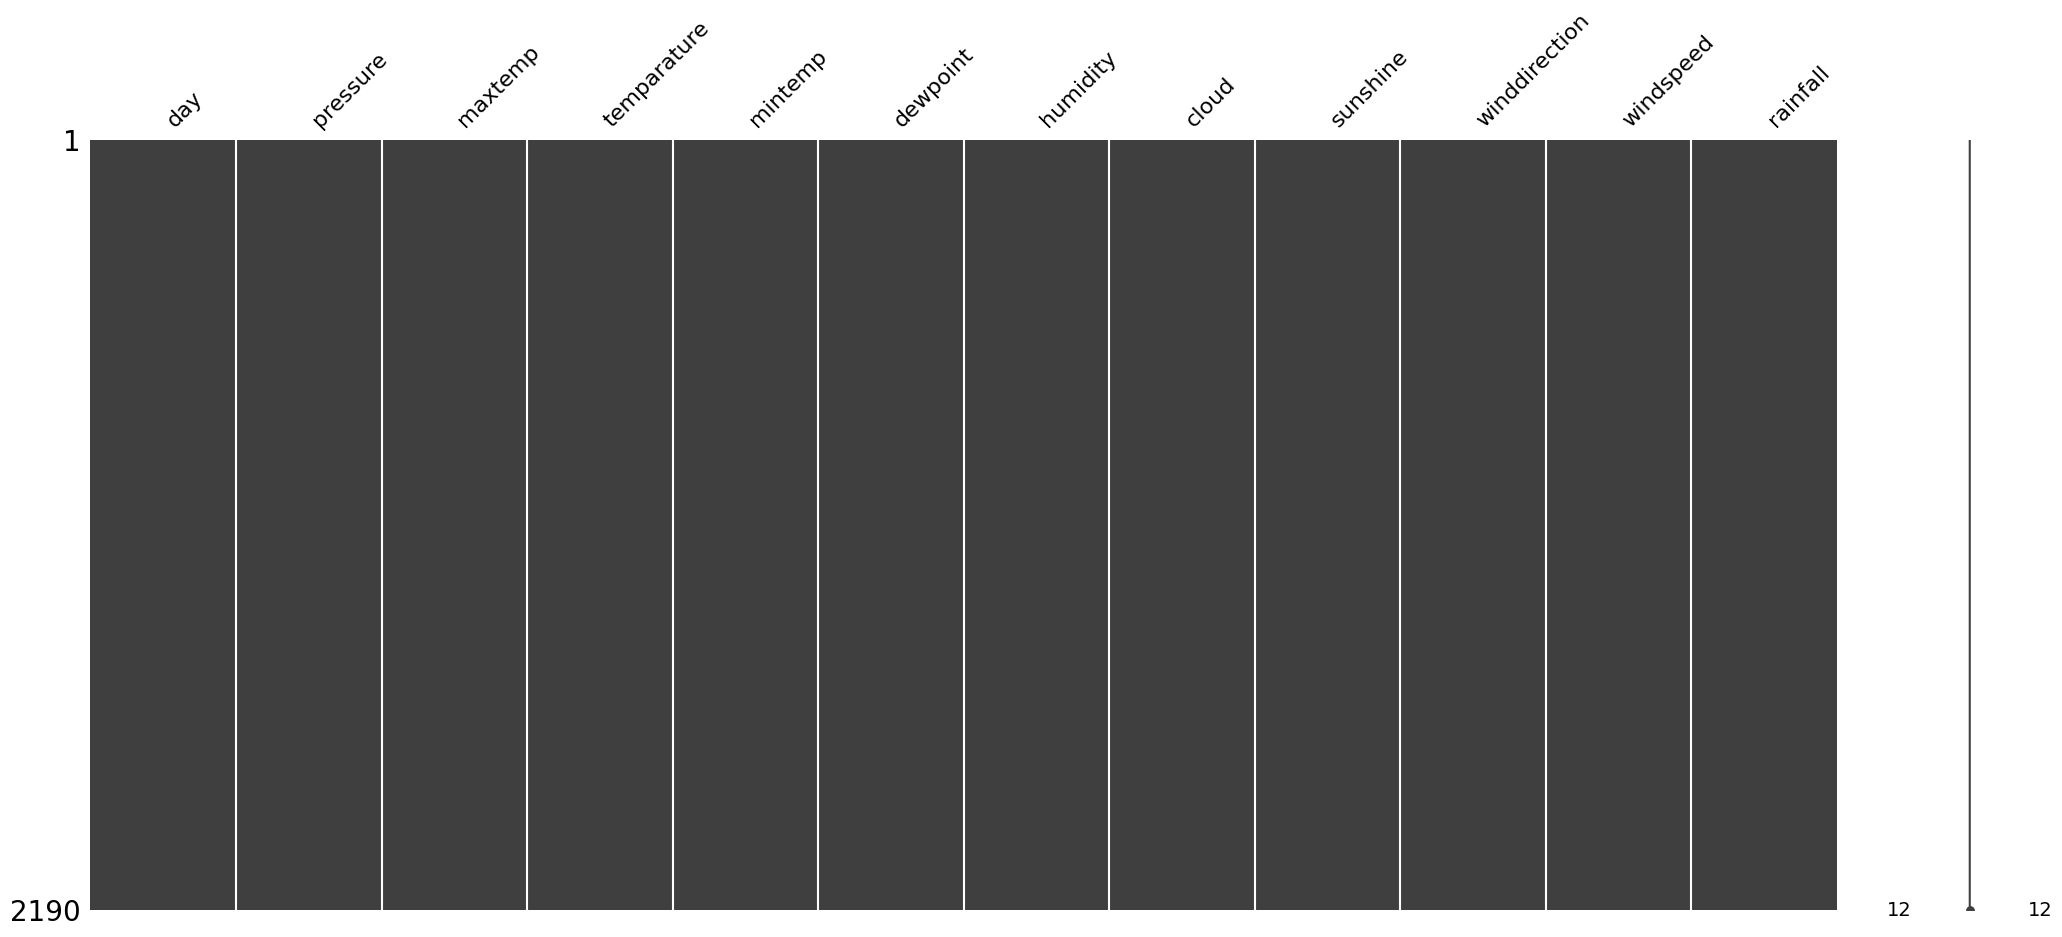

In [8]:
# double check for missing values, but expect none
missingno.matrix(train_df)

In [9]:
train_df.duplicated().sum()

np.int64(0)

No duplicated rows

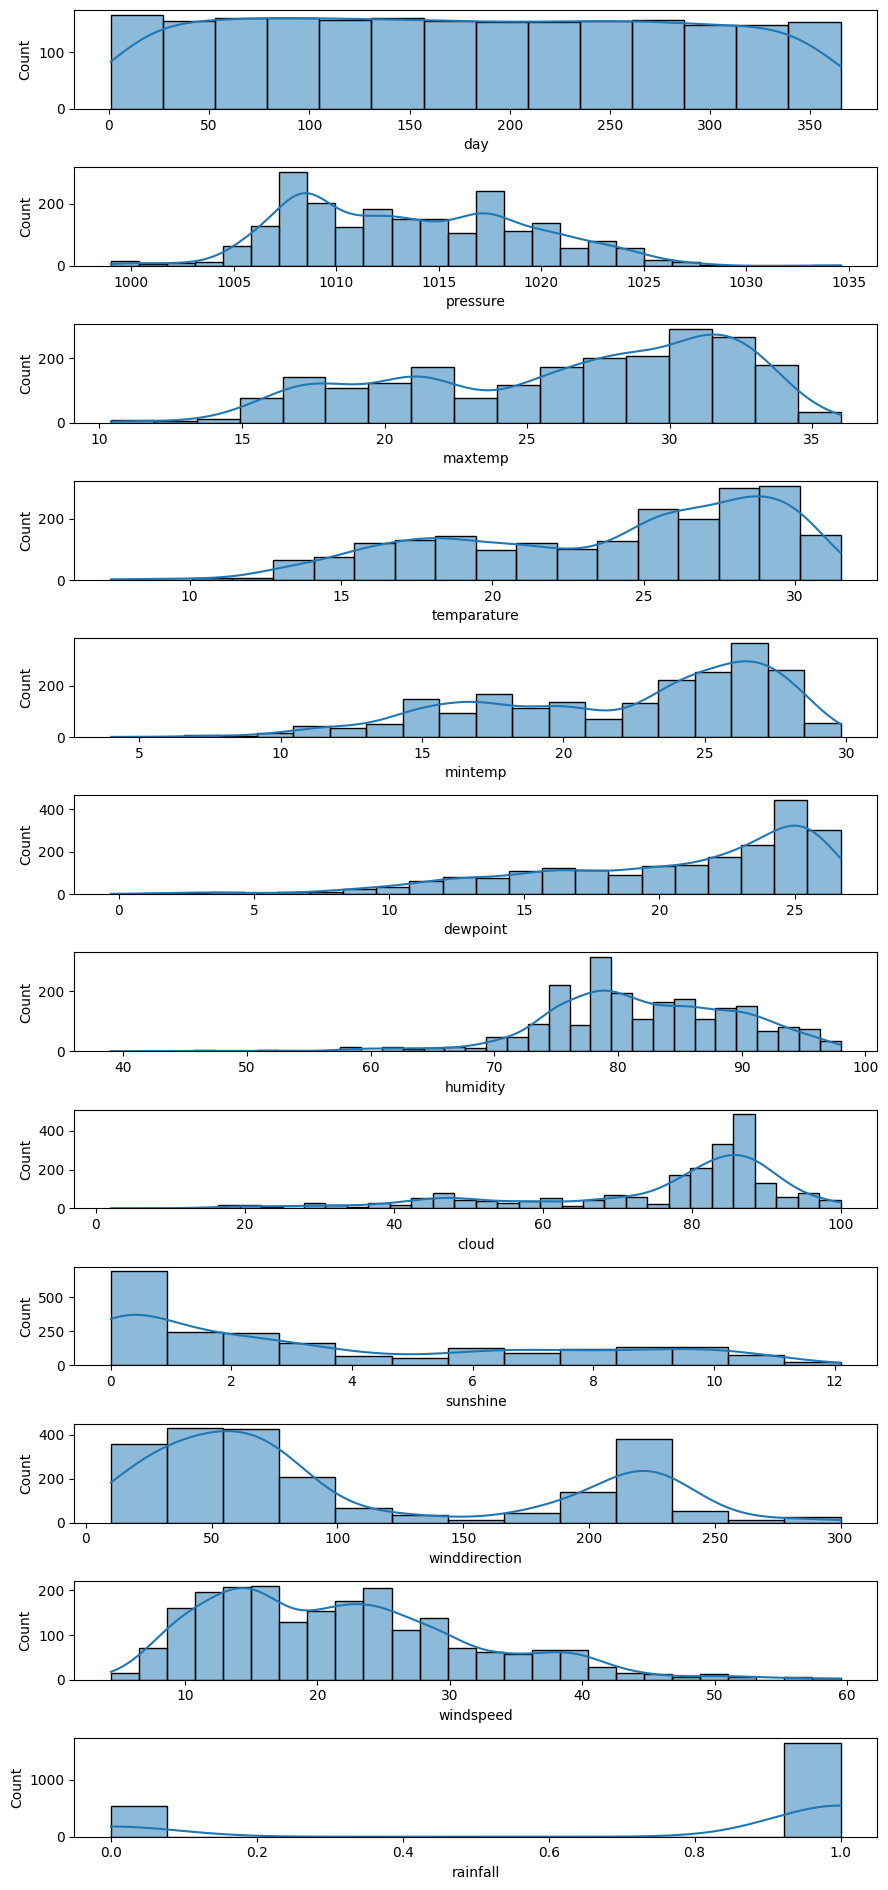

In [10]:
fig, ax = plt.subplots(nrows=len(ALL_COLUMNS), ncols=1, figsize=(9,19))

for i, column in enumerate(ALL_COLUMNS):
    sns.histplot(
        data=train_df,
        x=column,
        ax=ax[i],
        kde=True,
                 )

plt.tight_layout()
plt.show()

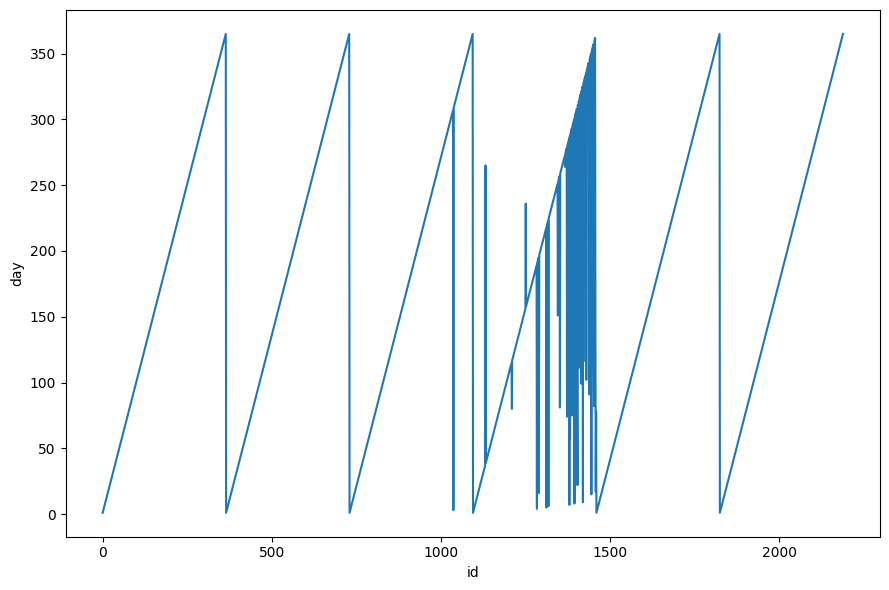

In [11]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(9,6)
)

sns.lineplot(
    train_df,
    x=train_df.index,
    y='day',
    ax=ax
    
)

plt.tight_layout()
plt.show()

In [12]:
train_df['day'].value_counts()

day
6      7
7      7
8      7
9      7
22     7
      ..
344    5
345    5
363    5
364    5
365    5
Name: count, Length: 365, dtype: int64

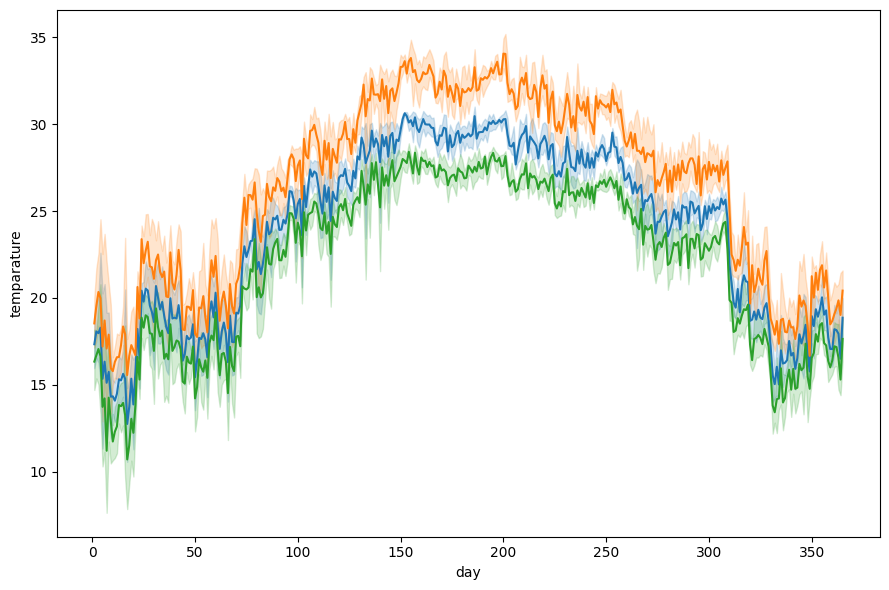

In [14]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(9,6)
)

sns.lineplot(
    train_df,
    x='day',
    y='temparature',
    ax=ax
    
)
sns.lineplot(
    train_df,
    x='day',
    y='maxtemp',
    ax=ax
    
)
sns.lineplot(
    train_df,
    x='day',
    y='mintemp',
    ax=ax
    
)

plt.tight_layout()
plt.show()

In [23]:
# check if max temp is always over temparature, as well as over for mintemp
print((train_df['maxtemp'] < train_df['temparature']).sum())
print((train_df['mintemp'] > train_df['temparature']).sum())

22
11


In [24]:
# see where maxtemp is under temparature
train_df.loc[train_df['maxtemp']<train_df['temparature']]

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
12,13,1020.4,15.0,15.5,13.2,12.0,77.0,86.0,0.0,50.0,32.4,1
319,320,1018.9,19.2,20.9,19.2,19.4,78.0,38.0,5.7,80.0,36.0,1
369,5,1022.4,12.1,13.8,11.2,2.7,75.0,68.0,6.0,70.0,27.6,0
398,34,1013.7,22.3,23.0,21.0,20.4,91.0,84.0,0.0,80.0,37.0,1
653,289,1016.6,26.2,26.8,23.2,20.4,79.0,69.0,5.0,40.0,22.4,1
702,338,1021.1,17.3,18.0,16.1,16.1,70.0,86.0,3.0,40.0,14.8,0
734,5,1024.4,11.3,11.4,10.4,8.6,77.0,88.0,0.0,20.0,39.3,1
796,67,1020.6,18.8,19.9,17.1,16.0,79.0,95.0,0.0,30.0,19.3,1


In [25]:
# see where mintemp is over temparature
train_df.loc[train_df['mintemp']>train_df['temparature']]

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
68,69,1015.0,17.8,16.0,16.9,16.6,90.0,51.0,9.5,60.0,24.9,0
675,311,1021.6,25.3,22.0,22.6,19.4,83.0,84.0,0.5,60.0,11.9,1
679,315,1016.4,21.9,18.6,18.8,15.4,76.0,88.0,8.6,70.0,26.8,1
802,73,1019.4,21.3,20.7,20.9,18.3,81.0,88.0,0.0,30.0,12.1,1
905,176,1005.4,31.1,28.4,28.8,25.5,84.0,86.0,6.8,220.0,16.7,1
1077,348,1017.9,20.6,18.8,19.1,17.8,85.0,91.0,0.3,40.0,13.0,1
1089,360,1019.5,17.7,16.0,16.5,16.5,93.0,97.0,0.0,50.0,21.4,1
1122,28,1024.6,16.1,13.0,13.5,11.9,76.0,89.0,0.0,200.0,33.2,0
1464,5,1027.1,10.8,7.4,8.1,2.5,61.0,95.0,0.1,20.0,24.0,1


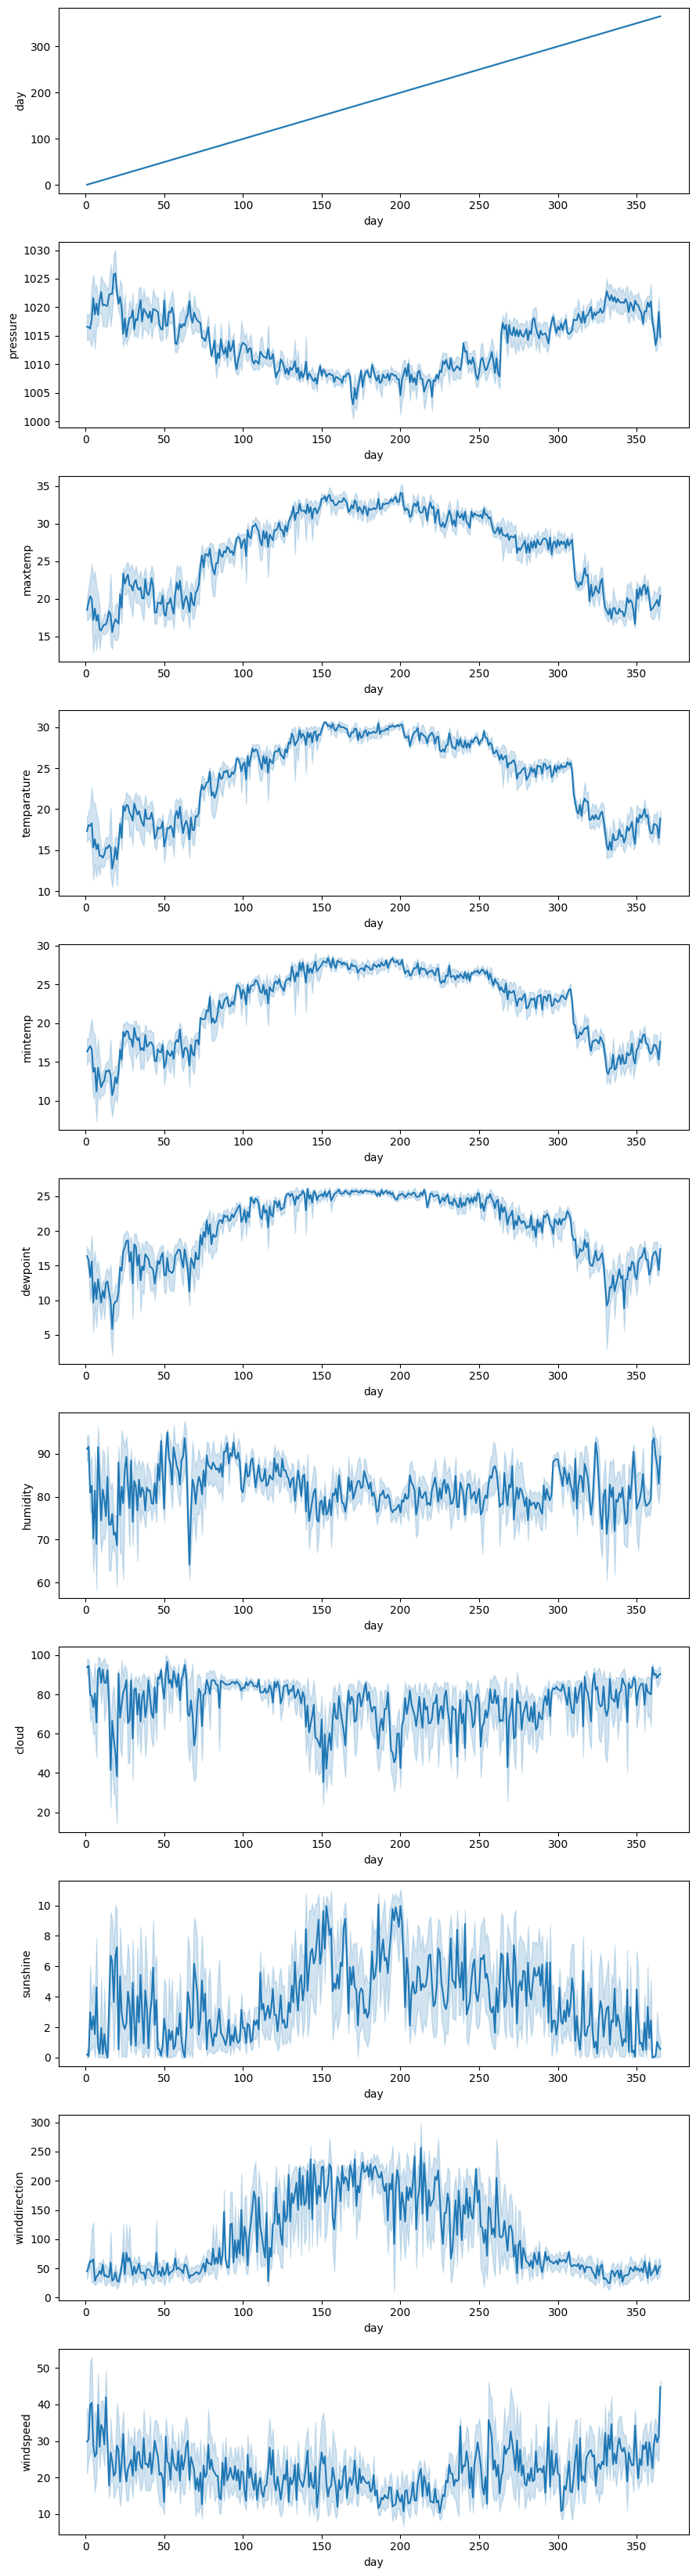

In [19]:
fig, ax = plt.subplots(
    nrows=len(NUMERIC_COLUMNS),
    ncols=1,
    figsize=(9, 3*len(NUMERIC_COLUMNS))
)

for i, column in enumerate(NUMERIC_COLUMNS):

    sns.lineplot(
        train_df,
        x='day',
        y=column,
        ax=ax[i]
    )

plt.tight_layout()
plt.show()